In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Each batch_size is used 10 times and we observe how the training loss and validation loss perform.

In [ ]:
# Parameters
n = 20  # context length
d = 5  # input dimension
L = 3  # number of layers
batch_size = 512
validation_size = batch_size // 8
epochs = 10000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set seeds

# for PyTorch
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# to ensure reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# distribution for x and w
def generate_data(batch_size, d, n, device):
    # x = (torch.rand(batch_size, n+1, d, device=device) - 0.5) * 2 * M  # uniform distribution. of shape (batch_size, n+1, d)
    x = torch.randn(batch_size, n+1, d, device=device) # normal distribution N(0, 1). of shape (batch_size, n+1, d)
    w_star = torch.randn(batch_size, d, device=device)  # normal distribution N(0, 1) of shape (batch_size, d)
    y = (x * w_star.unsqueeze(1)).sum(dim=2) # taking inner product of x_i and w for each batch. of shape(batch_size, n+1)
    return x, y, w_star # y[:,n] are the true y_{n+1} values

class LinearTransformer(nn.Module):
    def __init__(self, d, n, L, device):
        super(LinearTransformer, self).__init__()
        self.L = L
        self.n = n
        self.device = device

        # sparse P and Q
        self.P_list = nn.ParameterList([self.create_P_matrix(d, device) for _ in range(L)])
        self.Q_list = nn.ParameterList([self.create_Q_matrix(d, device) for _ in range(L)])

        self.M = torch.block_diag(torch.eye(n, device=device), torch.zeros(1,1, device=device))

    def create_P_matrix(self, d, device):
        # create a (d+1) x (d+1) matrix with the desired structure for P_i
        P = torch.zeros(d+1, d+1, device=device)
        P[-1, -1] = 1
        return nn.Parameter(P)

    def create_Q_matrix(self, d, device):
        # create a (d+1) x (d+1) matrix with the desired structure for Q_i
        Q = torch.zeros(d+1, d+1, device=device)
        A_i = torch.randn(d, d, device=device) * 0.1  # initialize A_i randomly
        Q[:d, :d] = A_i  # Place A_i in the top-left block
        return nn.Parameter(-Q)

    def forward(self, Z):
        # Z is given as shape (batch_size, d+!, n+1)
        batch_size = Z.shape[0]
        for l in range(self.L):
            P = self.P_list[l]
            Q = self.Q_list[l]
            # batched version of Z_tilde = Z.T @ Q @ Z
            Z_tilde = torch.bmm(Z.transpose(1, 2), Q.unsqueeze(0).expand(batch_size, -1, -1))
            Z_tilde = torch.bmm(Z_tilde, Z)

            # batched version of Attn_PQ = P @ Z @ self.M @ Z_tilde
            Attn_PQ = torch.bmm(P.unsqueeze(0).expand(batch_size, -1, -1), Z)
            Attn_PQ = torch.bmm(Attn_PQ, self.M.unsqueeze(0).expand(batch_size, -1, -1))
            Attn_PQ = torch.bmm(Attn_PQ, Z_tilde)
            Z = Z + Attn_PQ / self.n
        return Z

In [ ]:
def loss_function(ZL, y_true):
    y_hat = -ZL[:,-1,-1] # shape (batch_size,)
    return torch.mean((y_hat - y_true)**2)

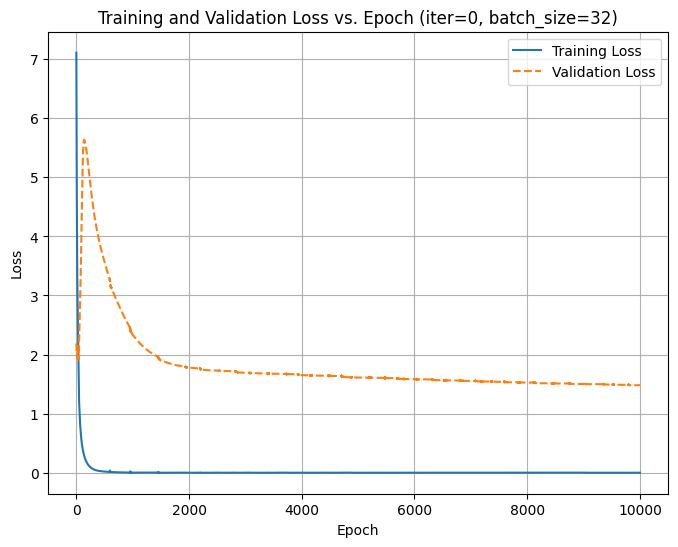

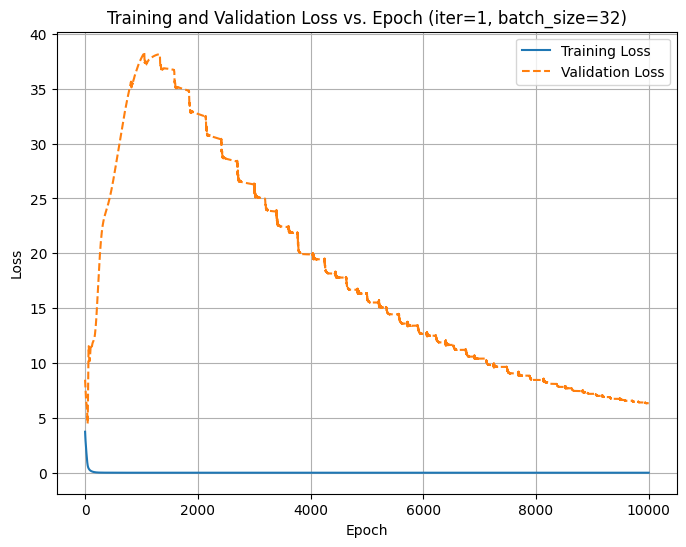

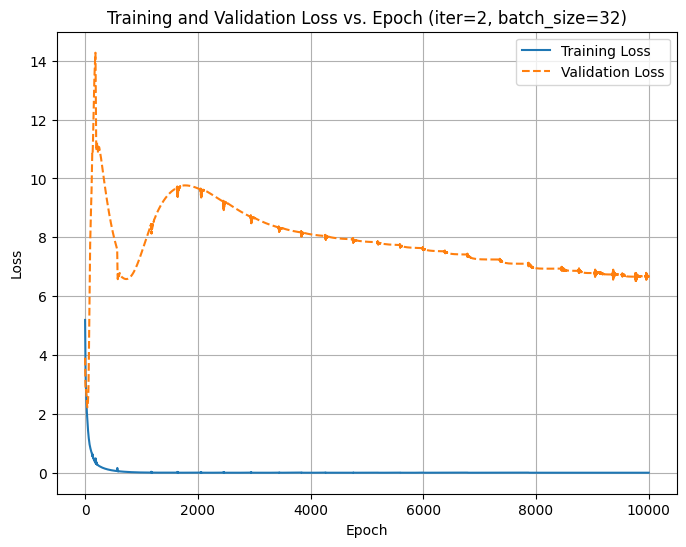

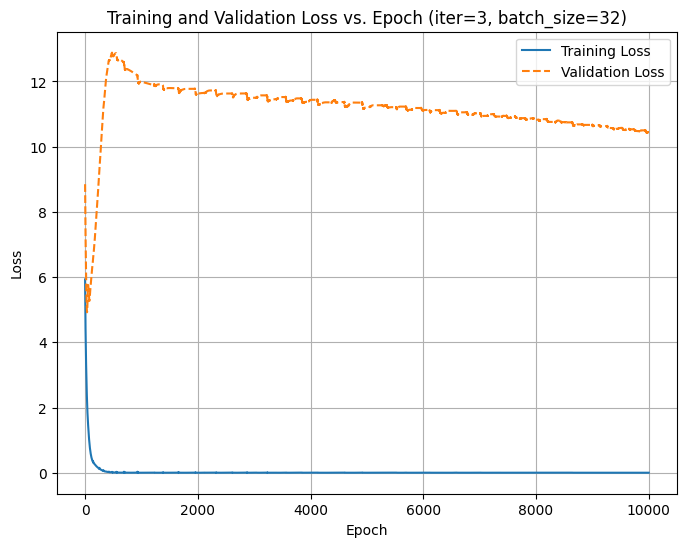

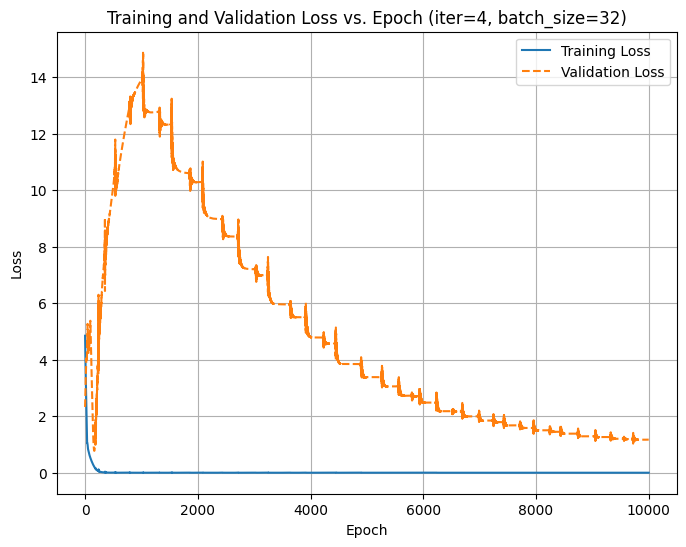

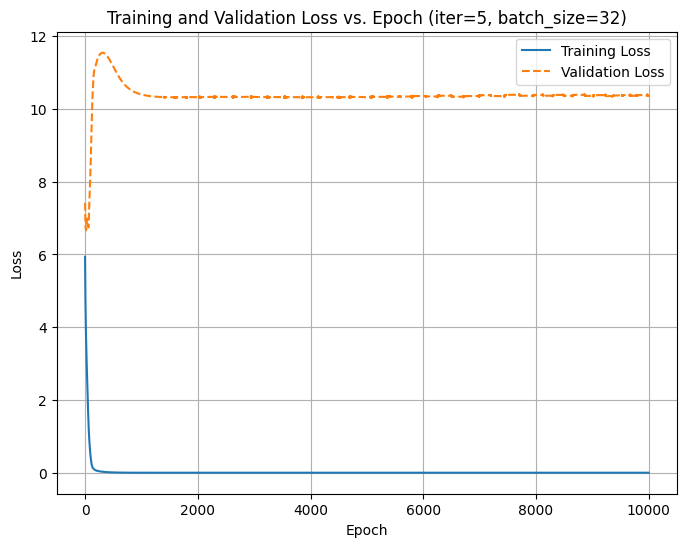

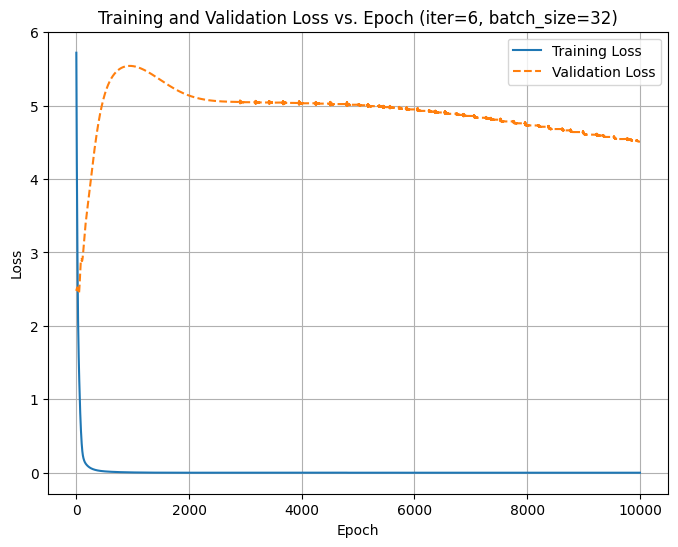

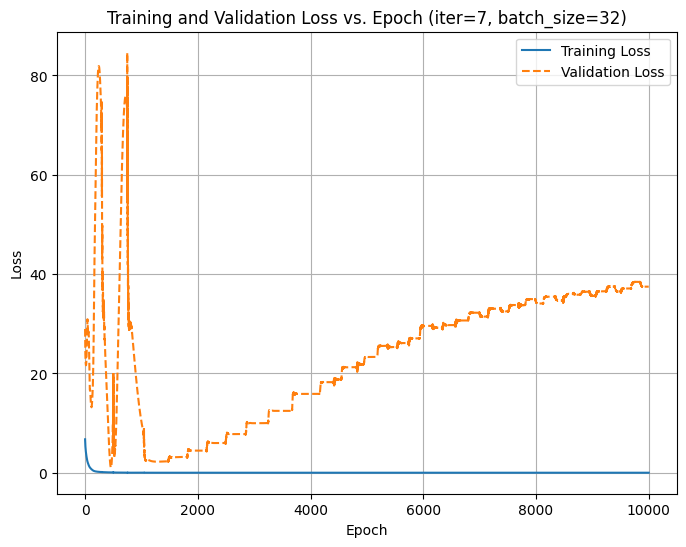

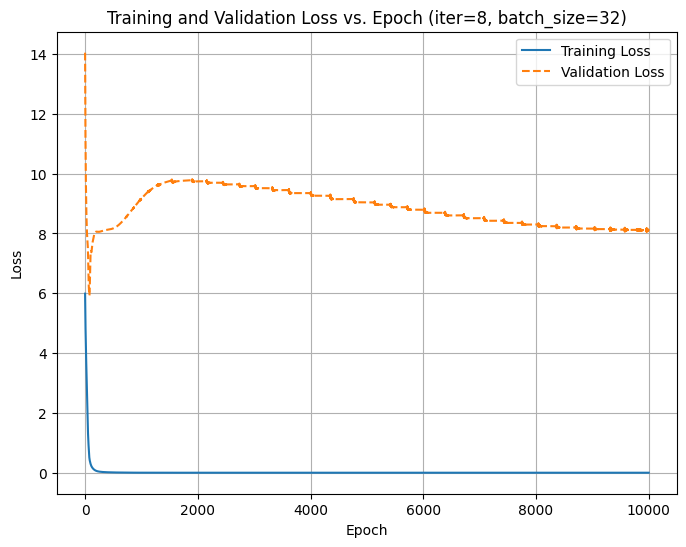

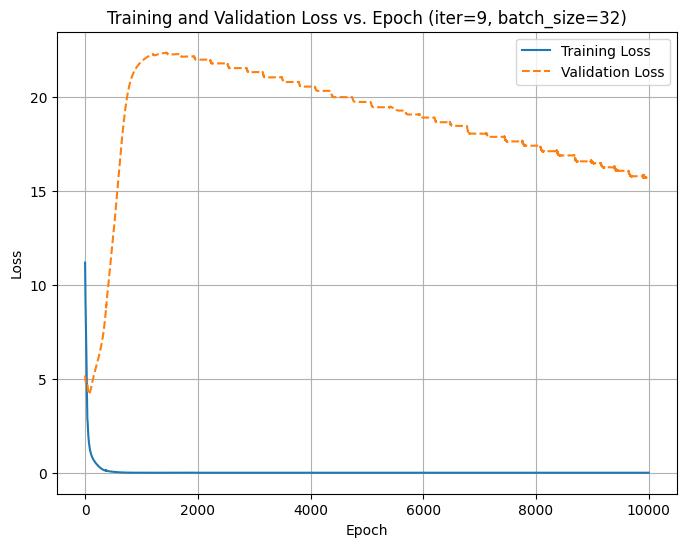

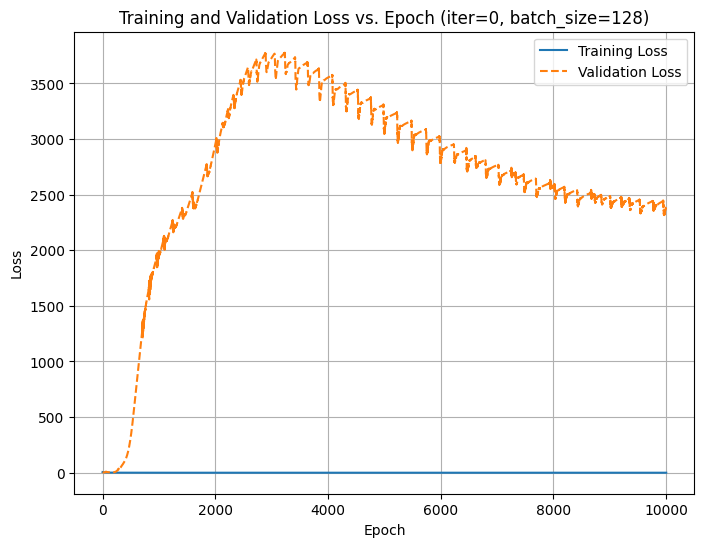

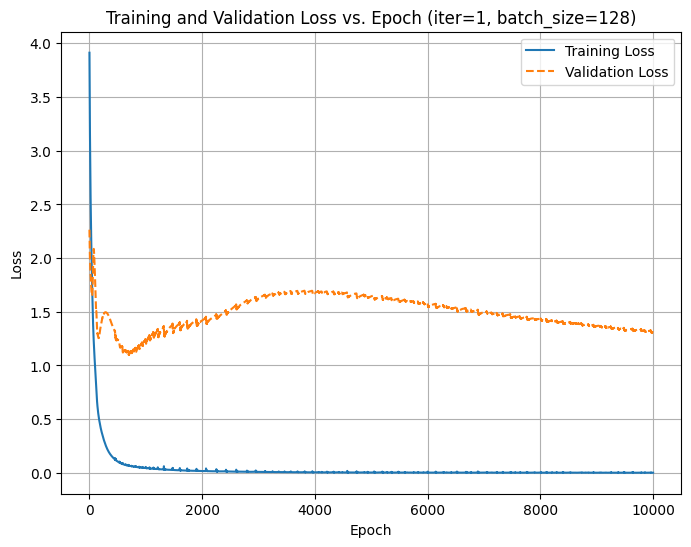

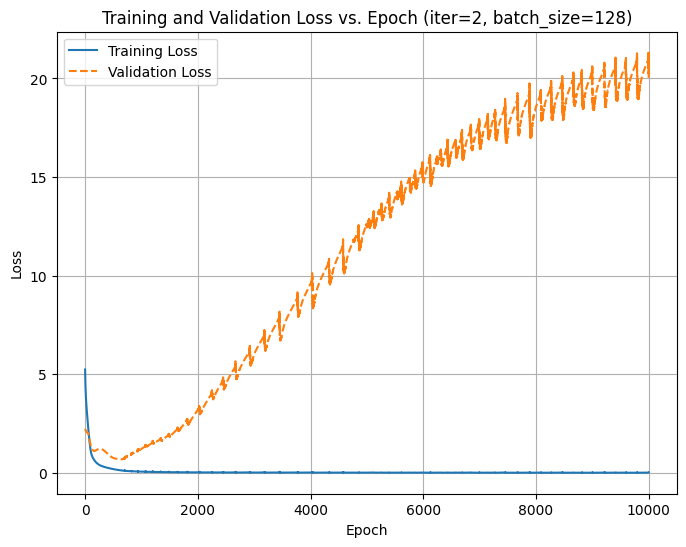

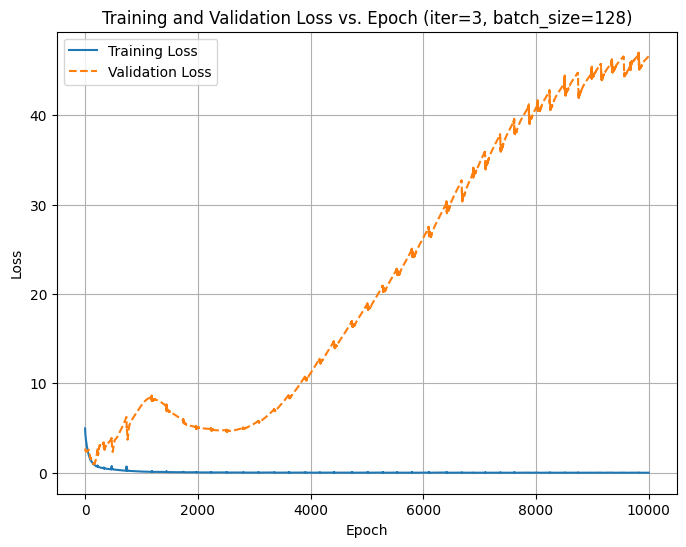

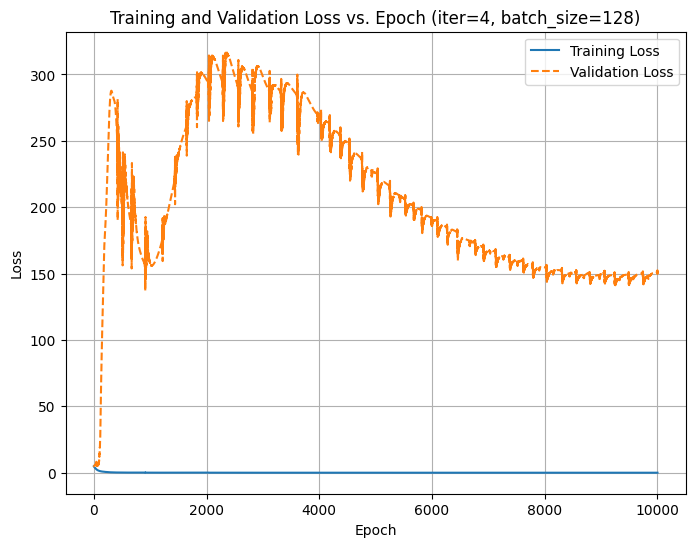

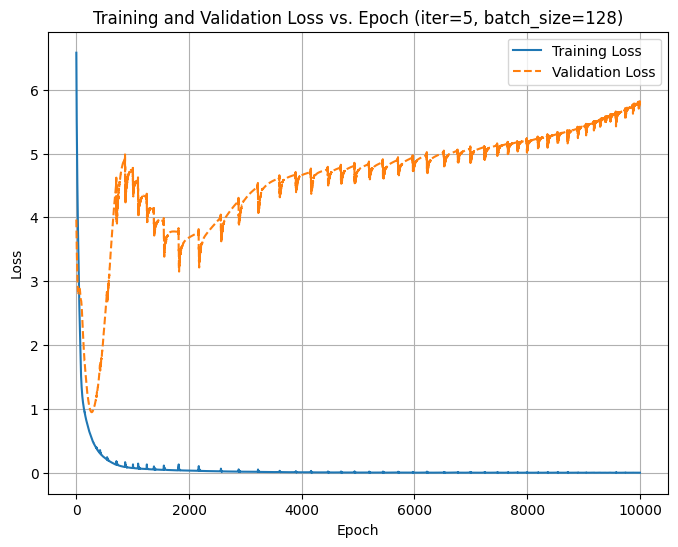

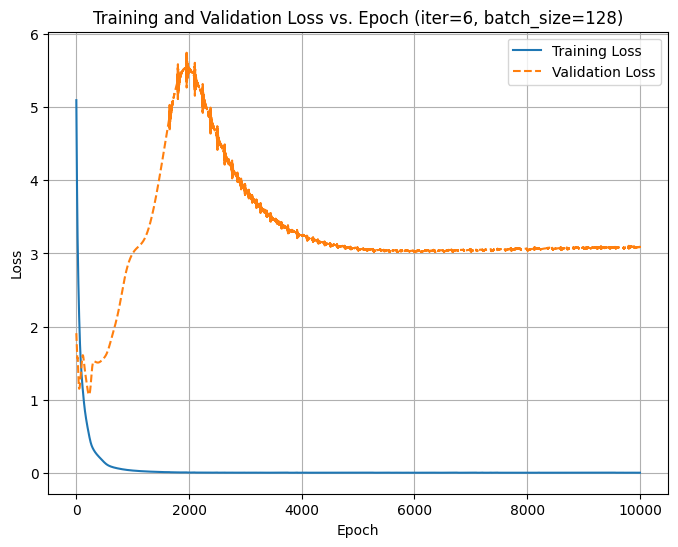

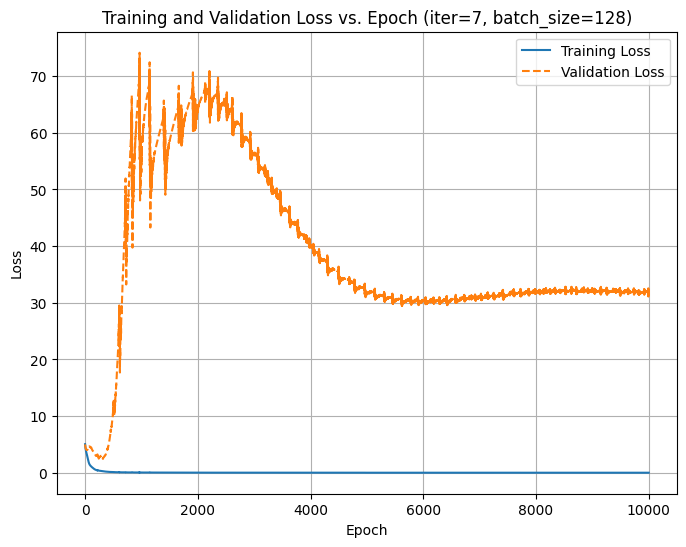

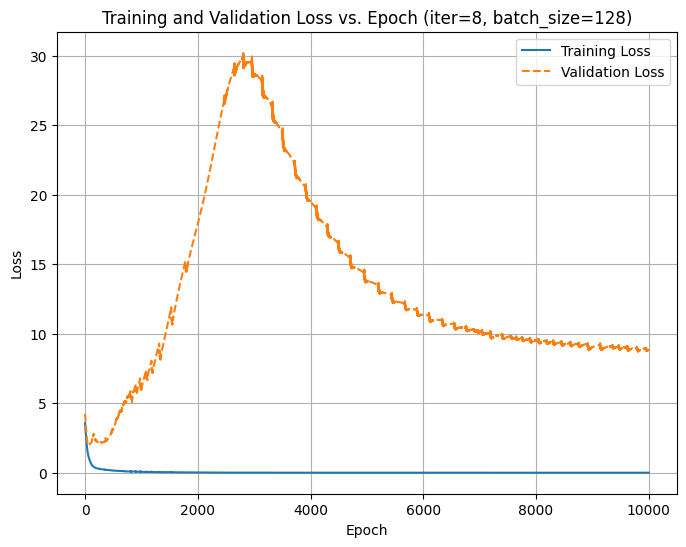

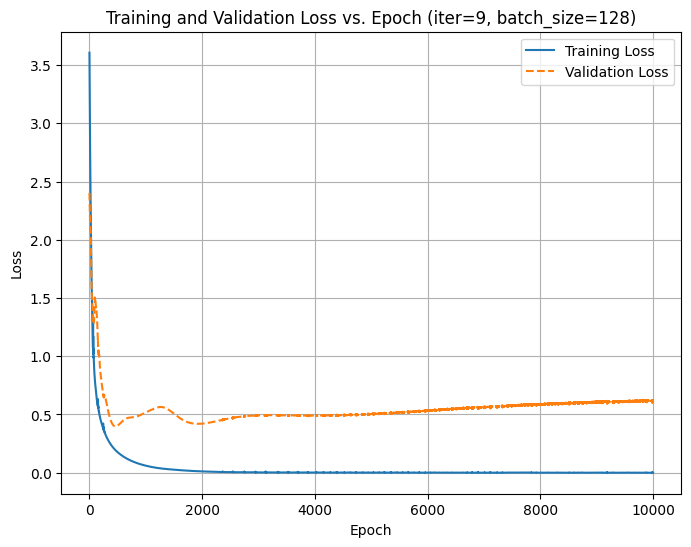

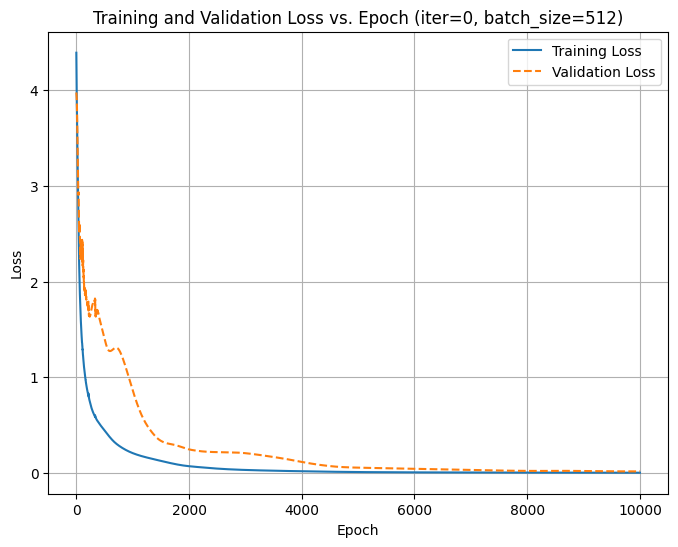

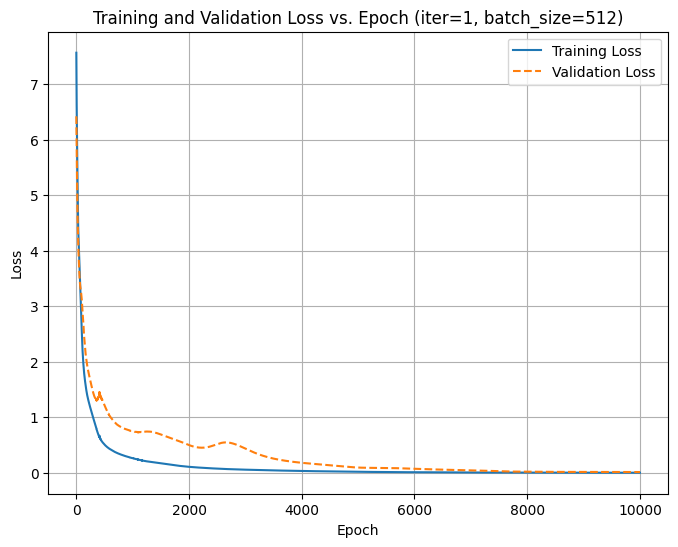

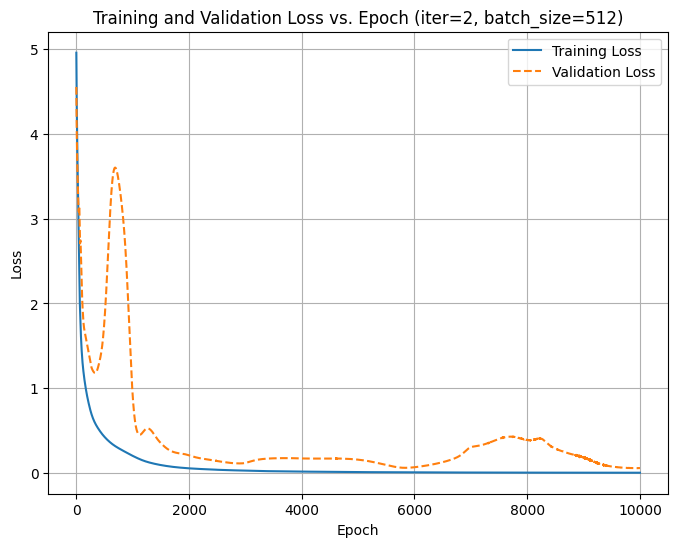

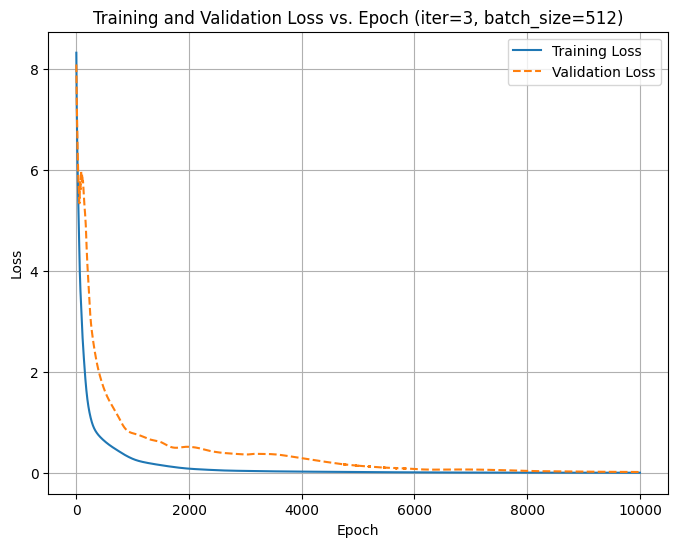

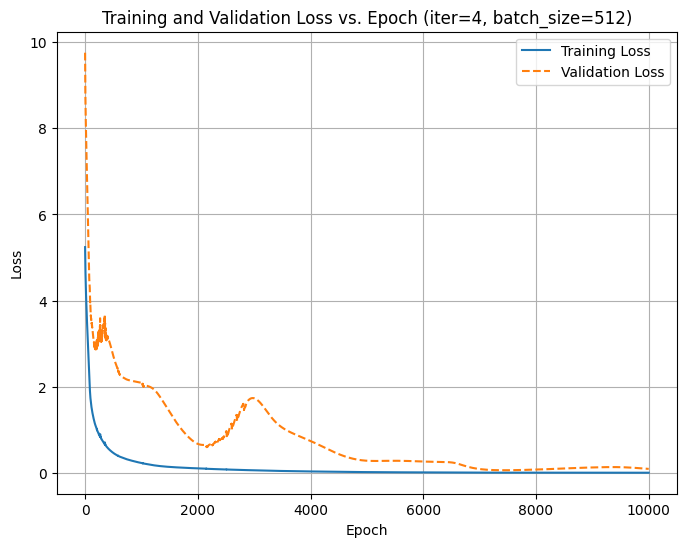

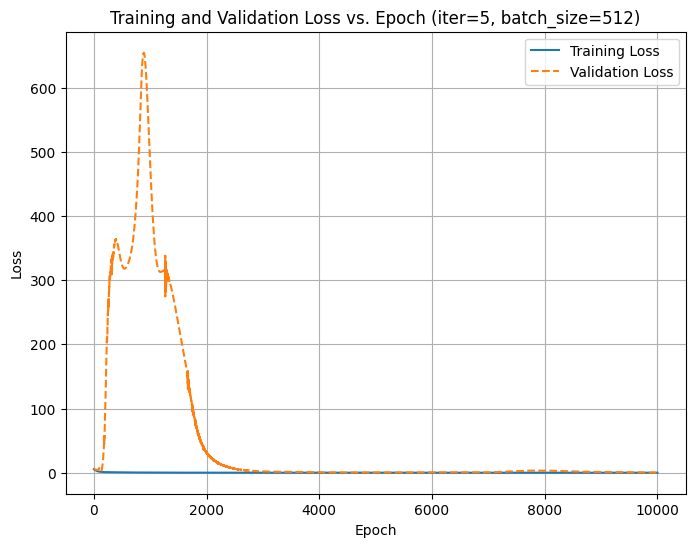

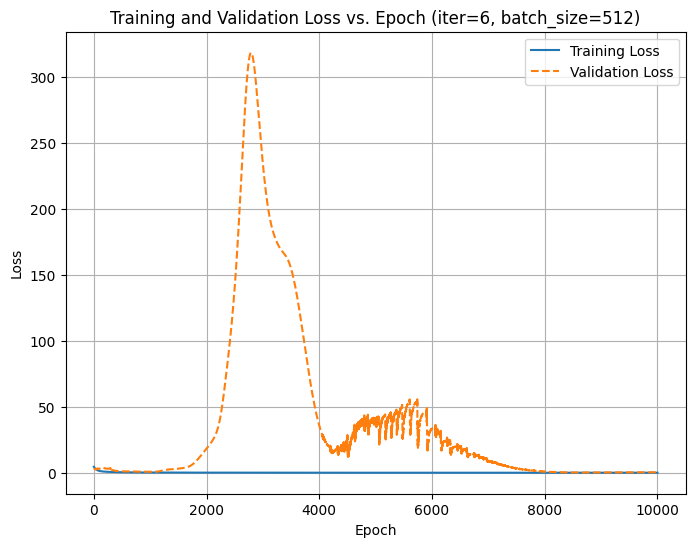

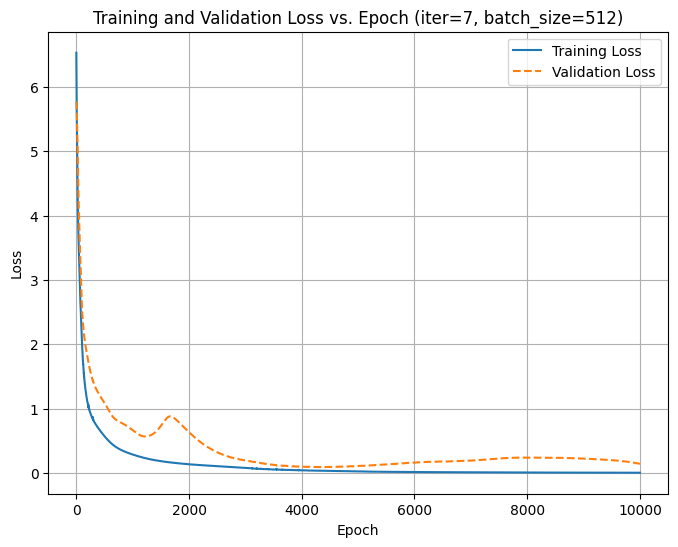

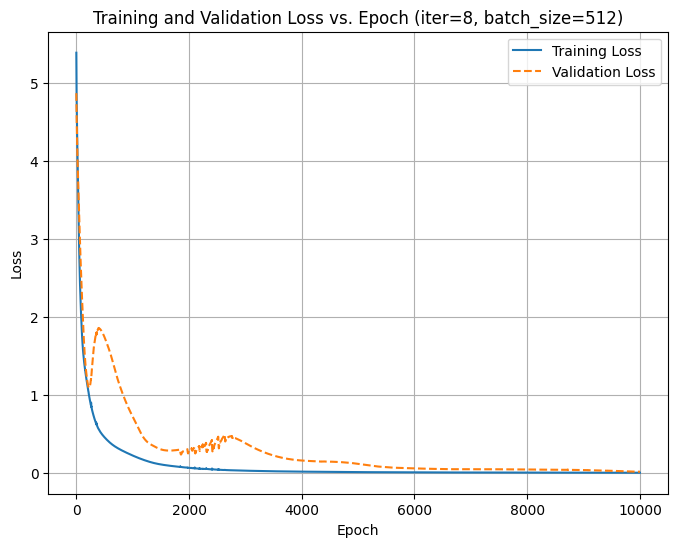

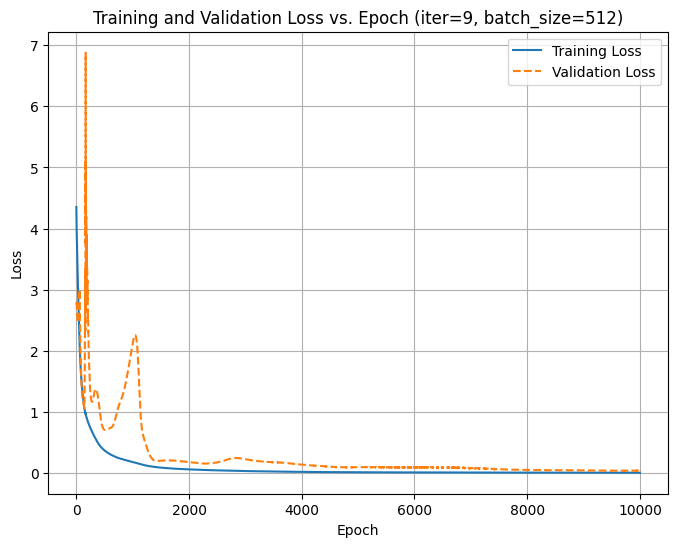

In [ ]:
# Hyperparameters for Adam optimizer
lr = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Function to apply Adam updates with added noise to the gradient
def adam_step(params, grads, m, v, t, lr, beta1, beta2, epsilon, noise_scale):
    updated_params = []
    for idx, (param, grad) in enumerate(zip(params, grads)):
        # Add noise to gradient
        noisy_grad = grad + torch.randn_like(grad) * noise_scale

        # Update biased first moment estimate
        m[idx] = beta1 * m[idx] + (1 - beta1) * noisy_grad

        # Update biased second moment estimate
        v[idx] = beta2 * v[idx] + (1 - beta2) * (noisy_grad ** 2)

        # Compute bias-corrected first moment estimate
        m_hat = m[idx] / (1 - beta1 ** t)

        # Compute bias-corrected second moment estimate
        v_hat = v[idx] / (1 - beta2 ** t)

        # Update parameters
        param_update = param - lr * m_hat / (torch.sqrt(v_hat) + epsilon)
        updated_params.append(param_update)

    return updated_params, m, v


train_val_losses = []

# we search for large enough size of training set (batch_size)
list_batch_val = [[2 ** i, 2 ** (i - 3)] for i in [5,7,9]]

for batch_size, validation_size in list_batch_val:
    train_loss_this_size = []
    val_loss_this_size = []
    # testing by setting noise_scale = 0 (no noise)
    for iter in range(10):
        # generate both training and validation data
        train_x, train_y, _ = generate_data(batch_size, d, n, device)
        val_x, val_y, _ = generate_data(validation_size, d, n, device)

        # initialize the model, optimizer, and loss function
        model = LinearTransformer(d=d, n=n, L=L, device=device).to(device)

        # Adam's momentum (m) and second moment (v) terms
        m = [torch.zeros_like(param) for param in model.parameters()]
        v = [torch.zeros_like(param) for param in model.parameters()]

        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            model.train()

            # zero-out gradients manually before each training step
            for param in model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

            # forward pass and loss calculation
            Z0 = torch.cat((torch.transpose(train_x,1,2), train_y.unsqueeze(1)), dim=1)  # concatenating x and y to form Z
            Z0[:,-1,-1] = 0 # initialize y_{n+1} as 0
            ZL = model(Z0)  # Apply the linear transformer
            train_loss = loss_function(ZL, train_y[:,-1])

            # backward pass and manual Adam update with noise
            grads = torch.autograd.grad(train_loss, model.parameters(), create_graph=False)

            # Set updated parameters back to the model
            with torch.no_grad():
                # manually perform an Adam step with noisy gradients
                updated_params, m, v = adam_step(list(model.parameters()), grads, m, v, epoch+1, lr, beta1, beta2, epsilon, noise_scale=0.0)
                for param, updated_param in zip(model.parameters(), updated_params):
                    param.copy_(updated_param)

            # Validation phase
            model.eval()
            with torch.no_grad():
                val_Z0 = torch.cat((torch.transpose(val_x, 1, 2), val_y.unsqueeze(1)), dim=1)
                val_Z0[:,-1,-1] = 0  # initialize y_{n+1} as 0 for validation
                val_ZL = model(val_Z0)
                val_loss = loss_function(val_ZL, val_y[:, -1])

            train_losses.append(train_loss.item())
            val_losses.append(val_loss.item())

        train_loss_this_size.append(train_losses[-1])
        val_loss_this_size.append(val_losses[-1])

        # Plot the loss over epochs
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
        plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', linestyle='--')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training and Validation Loss vs. Epoch (iter={iter}, batch_size={batch_size})')
        plt.legend()
        plt.grid(True)
        plt.show()

    train_val_losses.append(list(zip(train_loss_this_size, val_loss_this_size)))

In [ ]:
print(train_val_losses)

[[(1.2869687260330664e-10, 1.4813610315322876), (1.6581530815074075e-07, 6.339086532592773), (7.95739560999209e-06, 6.669032573699951), (2.526573371142149e-05, 10.441219329833984), (9.040537406690419e-06, 1.1706503629684448), (5.408001015894115e-06, 10.35683822631836), (1.0057795662987701e-07, 4.508780002593994), (1.490328305209232e-09, 37.466609954833984), (2.15011345972016e-06, 8.105757713317871), (4.384963858683477e-08, 15.723138809204102)], [(0.001067114295437932, 2384.993896484375), (0.0005881293909624219, 1.3108723163604736), (0.021519433706998825, 19.956920623779297), (0.0008339659543707967, 46.608097076416016), (0.0017168601043522358, 148.59677124023438), (0.0003763744607567787, 5.8166069984436035), (4.224230724503286e-05, 3.0923027992248535), (0.0009132144041359425, 32.04459762573242), (1.80907518370077e-05, 8.83239459991455), (0.000269545940682292, 0.6174913048744202)], [(0.002096019685268402, 0.015890151262283325), (0.002387399785220623, 0.014746638014912605), (0.00207840092